#MOVIE RECOMMENDATION SYSTEM


##Group 20
##*Devi Prasad Maharathy(B20AI053),Aman Thakur(B20AI003),Kaustabh Mishra(B20AI063)*

###Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.pyplot import figure
from sklearn.neighbors import NearestNeighbors
import seaborn as sb

###Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Loading the dataset

In [ ]:
links=pd.read_csv('/content/drive/MyDrive/PRML Project/links.csv')
movies=pd.read_csv('/content/drive/MyDrive/PRML Project/movies.csv')
ratings=pd.read_csv('/content/drive/MyDrive/PRML Project/ratings.csv')
tags=pd.read_csv('/content/drive/MyDrive/PRML Project/tags.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.duplicated().sum()

0

In [ ]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.duplicated().sum()

0

In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
links.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [ ]:
movies.shape,tags.shape,ratings.shape,links.shape

((9742, 3), (3683, 4), (100836, 4), (9742, 3))

###Creating a dataset with movie titles and its corresponding ratings

In [ ]:
mov_t=pd.DataFrame(movies[['movieId','title']])
mov_t

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [ ]:
movie_title_rating=pd.merge(ratings,mov_t,how='inner',on='movieId')
movie_title_rating.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [ ]:
rf_dataset=movie_title_rating.groupby(by=['userId','title'],as_index=False).agg({"rating":"mean"})

In [ ]:
rf_dataset

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0
...,...,...,...
100827,610,[REC] (2007),4.0
100828,610,[REC]² (2009),3.5
100829,610,[REC]³ 3 Génesis (2012),3.0
100830,610,xXx (2002),2.0


####The rf_dataset contains the userId,title and rating groupbyed the userId

###Plotting the count for each rating

Text(0.5, 1.0, 'Distribution of ratings')

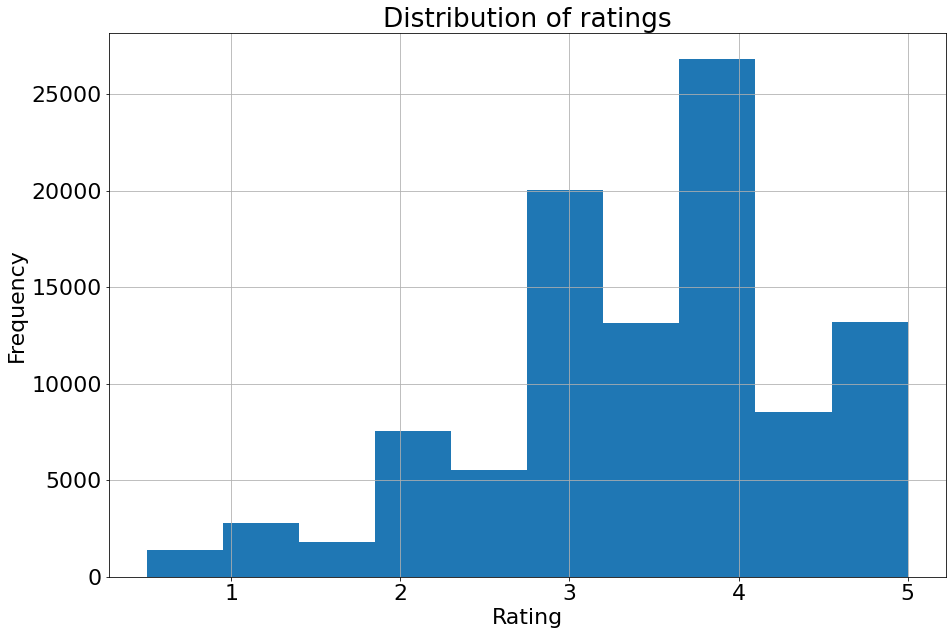

In [ ]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 22})
ratings['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

####The above plot tells us that most of the users who watched movies gave it a rating of 4 followed by 3.

###Visualizing the count of each movies

In [ ]:
movies_count=pd.DataFrame(ratings.groupby('movieId').size(),columns=['movie_count'])

In [ ]:
movies_count

,movie_count
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


Text(0, 0.5, 'number of ratings')

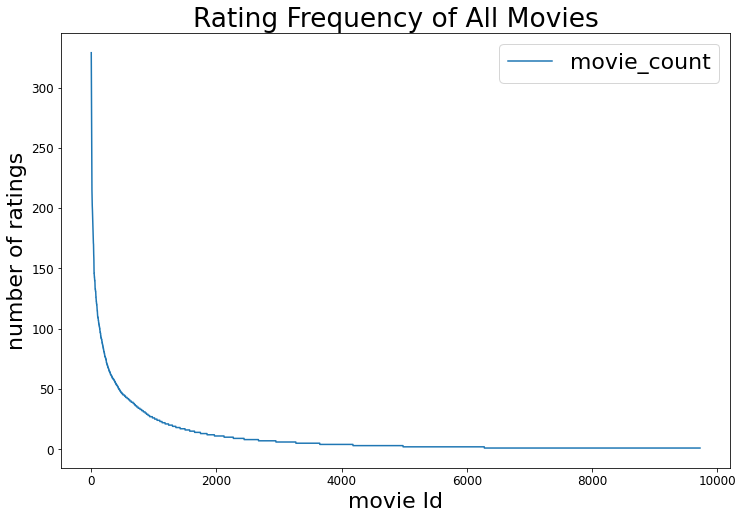

In [ ]:
ax = movies_count \
    .sort_values('movie_count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

We can see the issue of long tail property in this dataset. i.e movie after Id 2000 to 9724 have very less number of user ratings.We will deal with issue later

###Visualisation


In [ ]:
num_user_vote=ratings.groupby('movieId')['rating'].agg('count')
num_movies_vote=ratings.groupby('userId')['rating'].agg('count')
avg_rating=ratings.groupby('movieId')['rating'].sum()
avg_rating

movieId
1         843.0
2         377.5
3         169.5
4          16.5
5         150.5
          ...  
193581      4.0
193583      3.5
193585      3.5
193587      3.5
193609      4.0
Name: rating, Length: 9724, dtype: float64

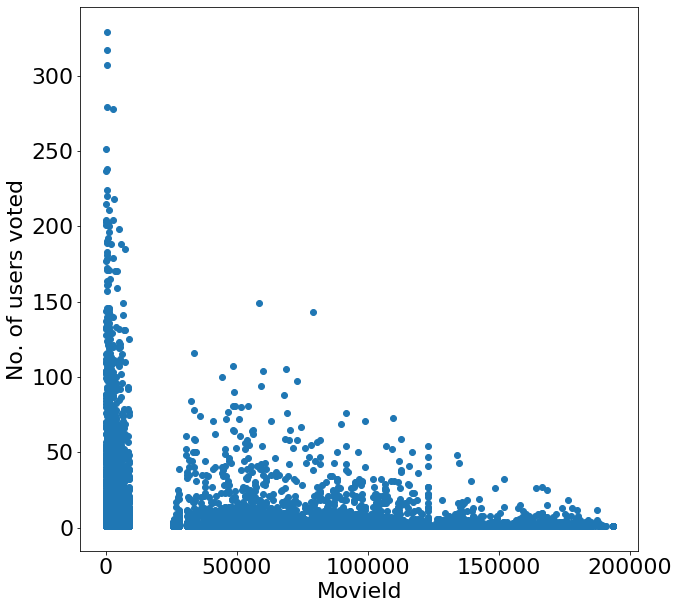

In [ ]:
figure(figsize=(10,10))
plt.scatter(num_user_vote.index,num_user_vote)
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

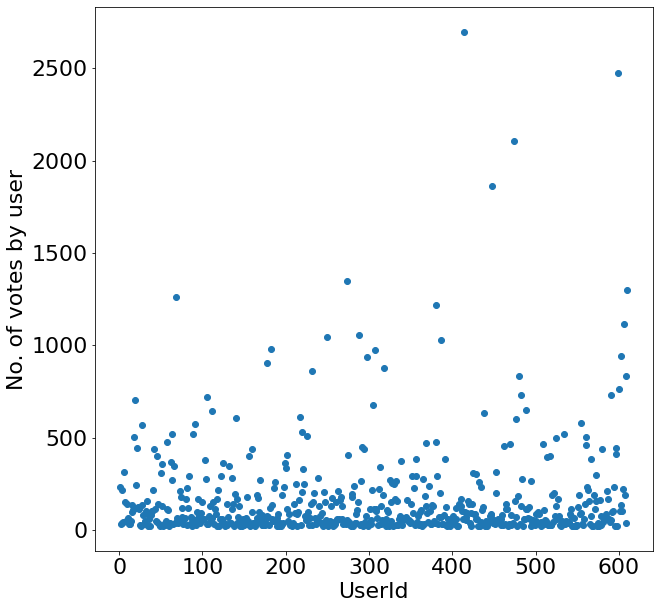

In [ ]:
figure(figsize=(10,10))
plt.scatter(num_movies_vote.index,num_movies_vote)
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

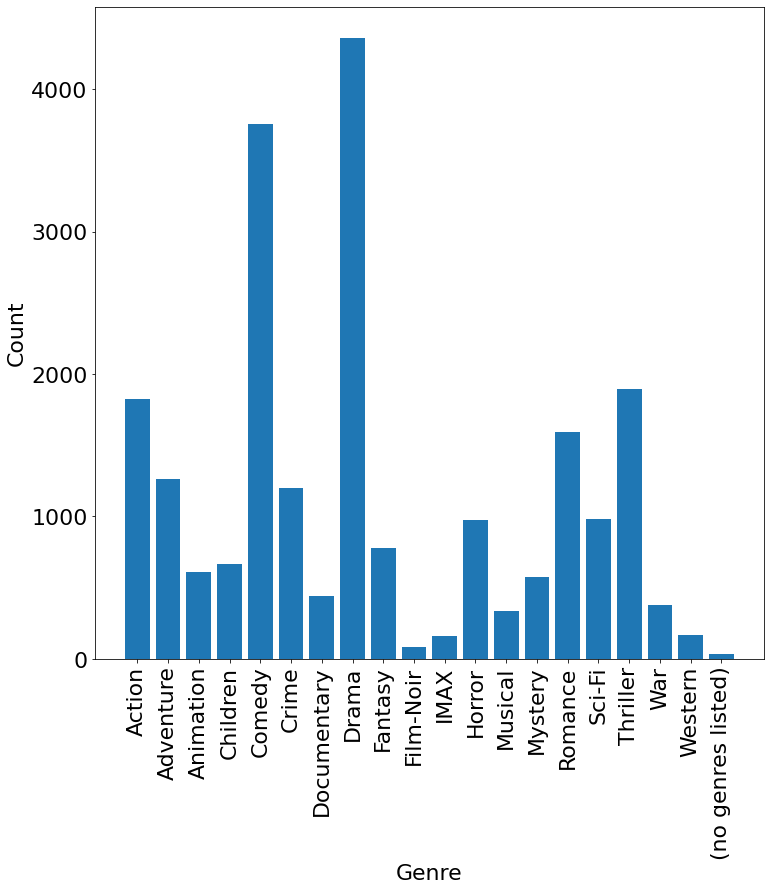

In [ ]:
figure(figsize=(12,12))

e=["Action","Adventure","Animation","Children","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","IMAX","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western","(no genres listed)"]
count=[0]*len(e)

for i in range(len(movies)):
    a=movies.iloc[i]["genres"].split("|")
    for j in a:
        count[e.index(j)]+=1

plt.bar(e,count)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

###Creating a df_movie dataset which has the movieId as the column number and the userId as the row number

In [ ]:
df_movie=ratings.pivot(index='userId',columns='movieId',values='rating')
df_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[]

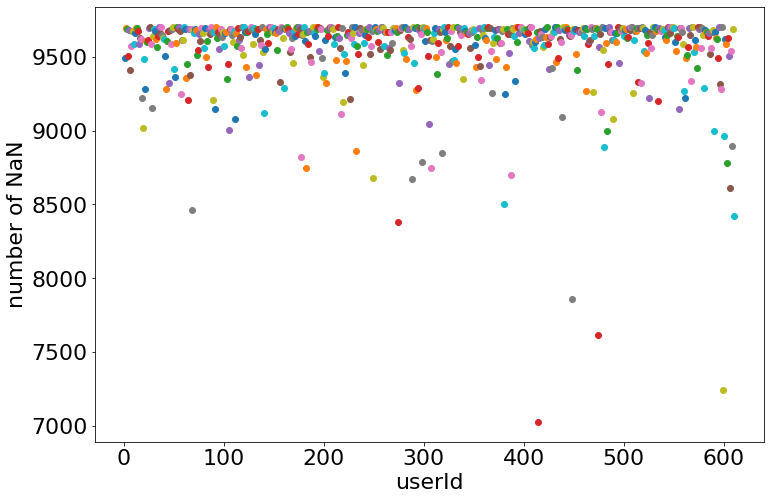

In [ ]:
figure(figsize=(12,8))
for i in range(len(df_movie)):
    plt.scatter(df_movie.iloc[:,0].index[i],df_movie.iloc[[i]].isna().sum().sum())
plt.xlabel("userId")
plt.ylabel("number of NaN")
plt.plot()

In [ ]:
df_movie.fillna(0,inplace=True)
df_movie

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#KNN (based on userId)

####Creating a sparse matrix from the df_movie dataset so that we can operate on it further smoothly

In [ ]:
user_movie_sparse=csr_matrix(df_movie.values)
user_movie_sparse

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

####Fitting the K Nearest Neighbours model to the sparse matrix

In [ ]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_movie_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

####Further we define a function to get the top k (k is passed of as an argument to the function) users matching a given user.

In [ ]:
def similar_users(userId,n_users=10):
  knn_input=np.asarray([df_movie.values[userId-1]])
  dists,idxs=knn_model.kneighbors(knn_input,n_neighbors=n_users+1)
  
  print(f'Top {n_users} users who are the most similar to user {userId} are: ')
  for i in range(1,len(dists[0])):
    print(f'{i} User {idxs[0][i]+1} separated by distance of {dists[0][i]}')
  return idxs.flatten()[1:]+1,dists.flatten()[1:]

####Testing this similar_user() function

In [ ]:
from pprint import pprint

In [ ]:
user_id = 77
print( f'Some Movies seen by the User {user_id}:')
pprint(list(rf_dataset[rf_dataset['userId'] == user_id]['title'])[:10])
similar_user_list, distance_list = similar_users(user_id,10)

Some Movies seen by the User 77:
["Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",
 'Batman Begins (2005)',
 'Bourne Identity, The (2002)',
 'Bourne Ultimatum, The (2007)',
 'Catch Me If You Can (2002)',
 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)',
 'Dark Knight, The (2008)',
 'Donnie Darko (2001)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'Gladiator (2000)']
Top 10 users who are the most similar to user 77 are: 
1 User 399 separated by distance of 0.5303046091304774
2 User 30 separated by distance of 0.5512437341520852
3 User 407 separated by distance of 0.5706275328702807
4 User 189 separated by distance of 0.5986455270692603
5 User 25 separated by distance of 0.6184055063873423
6 User 86 separated by distance of 0.623934557446298
7 User 112 separated by distance of 0.6379959064605797
8 User 366 separated by distance of 0.6410001284979502
9 User 487 separated by distance of 0.6457905229877801
10 User 475 separated by distance of 0.6493705457630571


####Now from here there are two ways to proceed further in our recommendation journey
####i)Take the average of the existing rating given by the similar users and pick the top 10 or required number of movies to recommend to the input user.

####ii)Define weights to ratings by each similar user based on their distance from the input user.

####The second method seems like a better option from the first as it reduces the chances of recommending movies liked by the users who are relatively far away from the user(based on the knn distance)

In [ ]:
#assiging weights to each of the similar user
weightage_list=distance_list/np.sum(distance_list)
weightage_list

array([0.08740346, 0.09085459, 0.09404938, 0.09866723, 0.10192402,
       0.10283531, 0.10515286, 0.10564801, 0.10643755, 0.1070276 ])

In [ ]:
#Getting the ratings of the movies rated by these similar users
sim_users_ratings=df_movie.values[similar_user_list]
sim_users_ratings

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [5. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [4. , 4. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
#viewing the names of the movies in the df_movies_columns
movie_ids=df_movie.columns
movie_ids

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)

In [ ]:
movie_list=[]
for i in range(len(movie_ids)):
  movie_list.append(mov_t.loc[mov_t['movieId']==movie_ids[i]]['title'])

In [ ]:
movie_list=np.array(movie_list)

In [ ]:
movie_list=movie_list.flatten()

In [ ]:
movie_list

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

####Concatenating the weigtage matrix with zeroes so that it gets easier to get the movies from the df_movies matrix by taking the cross product

In [ ]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movie_list))
weightage_list.shape

(10, 9724)

In [ ]:
new_rating_matrix = weightage_list*sim_users_ratings
mean_rating = new_rating_matrix.sum(axis =0)
mean_rating

array([1.88959237, 0.4281104 , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
def recommend_movies(n):
  n = min(len(mean_rating),n)
  print(list(movie_list[np.argsort(mean_rating)[::-1][:n]]))

In [ ]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)', 'Forrest Gump (1994)', 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'Casablanca (1942)', 'Toy Story (1995)', 'Godfather, The (1972)', 'Star Wars: Episode IV - A New Hope (1977)', 'Good Will Hunting (1997)', 'Monty Python and the Holy Grail (1975)']


This recommender system has some drawbacks 

i)It can at times recommend movies which are already seen by the input user

ii)It can also recommend movies not seen by any of the similar users

We tried to built a new model based on these limitations

In [ ]:
def filtered_movie_recommendations(n):
  
  first_zero_index = np.where(mean_rating == 0)[0][-1]
  sortd_index = np.argsort(mean_rating)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(rf_dataset[rf_dataset['userId'] == user_id]['title'])
  filtered_movie_list = list(movie_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    for i in final_movie_list:
      print(i)
    #print(final_movie_list)

In [ ]:
filtered_movie_recommendations(10)

Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Forrest Gump (1994)
Casablanca (1942)
Toy Story (1995)
Godfather, The (1972)
Good Will Hunting (1997)
Monty Python and the Holy Grail (1975)
Apollo 13 (1995)
Die Hard: With a Vengeance (1995)


####Making a final function that is to be imported for our website

In [ ]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  """print("Movie seen by the User:")
  pprint(list(rf_dataset[rf_dataset['userId'] == user_id]['title']))
  print("")"""

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def similar_users(userId,n_users=10):
    knn_input=np.asarray([df_movie.values[userId-1]])
    dists,idxs=knn_model.kneighbors(knn_input,n_neighbors=n_users+1)
    
    """print(f'Top {n_users} users who are the most similar to user {userId} are: ')
    for i in range(1,len(dists[0])):
      print(f'{i} User {idxs[0][i]+1} separated by distance of {dists[0][i]}')"""
    return idxs.flatten()[1:]+1,dists.flatten()[1:]


  def filtered_movie_recommendations(n):
  
    first_zero_index = np.where(mean_rating == 0)[0][-1]
    sortd_index = np.argsort(mean_rating)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(rf_dataset[rf_dataset['userId'] == user_id]['title'])
    filtered_movie_list = list(movie_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      for i in final_movie_list:
        print(i)

  similar_user_list, distance_list = similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  sim_users_ratings = df_movie.values[similar_user_list]
  movies_list = df_movie.columns
  movie_list=[]
  for i in range(len(movie_ids)):
    movie_list.append(mov_t.loc[mov_t['movieId']==movie_ids[i]]['title'])
  movie_list=np.array(movie_list)
  movie_list=movie_list.flatten()
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*sim_users_ratings
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [ ]:
print("Enter user id")
user_id= int(input())
print("Number of similar users to be considered")
sim_users = int(input())
print("Enter the number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
87
Number of similar users to be considered
6
Enter the number of movies to be recommended:
7

Movies recommended based on similar users are: 

Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Forrest Gump (1994)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Casablanca (1942)
Toy Story (1995)
Godfather, The (1972)


The movies recommended above were all found out on the basis of the userId provided to the function


####As an additional effort we are also aiming to reccomend movies based on movie similarity.After the user clicks on a movie several more movies can be recommended to him/her on the same streaming server.This will keep the chances of him continuing with the streaming app/website up and also increase the watch time of the service provider.

#KNN (based on movieId)

In [ ]:
df_user_movie=ratings.pivot(index='movieId',columns='userId',values='rating')
df_user_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#replacing the NaN entries with zero.
df_user_movie.fillna(0,inplace=True)
df_user_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#transforming the dataframe into sparse matrix
user_movie_sparse_df=csr_matrix(df_user_movie.values)
user_movie_sparse_df

<9724x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [ ]:
movies_ids = list(df_user_movie.index)
movie_list=[]
for i in range(len(movie_ids)):
  movie_list.append(mov_t.loc[mov_t['movieId']==movie_ids[i]]['title'])
movie_list=np.array(movie_list)
movie_list=movie_list.flatten()

In [ ]:
movie_list

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       ..., 'Flint (2017)', 'Bungo Stray Dogs: Dead Apple (2018)',
       'Andrew Dice Clay: Dice Rules (1991)'], dtype=object)

In [ ]:
movie_dict = {movie : index for index, movie in enumerate(movie_list)}
print(movie_dict)

{'Toy Story (1995)': 0, 'Jumanji (1995)': 1, 'Grumpier Old Men (1995)': 2, 'Waiting to Exhale (1995)': 3, 'Father of the Bride Part II (1995)': 4, 'Heat (1995)': 5, 'Sabrina (1995)': 6, 'Tom and Huck (1995)': 7, 'Sudden Death (1995)': 8, 'GoldenEye (1995)': 9, 'American President, The (1995)': 10, 'Dracula: Dead and Loving It (1995)': 11, 'Balto (1995)': 12, 'Nixon (1995)': 13, 'Cutthroat Island (1995)': 14, 'Casino (1995)': 15, 'Sense and Sensibility (1995)': 16, 'Four Rooms (1995)': 17, 'Ace Ventura: When Nature Calls (1995)': 18, 'Money Train (1995)': 19, 'Get Shorty (1995)': 20, 'Copycat (1995)': 21, 'Assassins (1995)': 22, 'Powder (1995)': 23, 'Leaving Las Vegas (1995)': 24, 'Othello (1995)': 25, 'Now and Then (1995)': 26, 'Persuasion (1995)': 27, 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28, 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29, 'Dangerous Minds (1995)': 30, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 31, 'Babe (1995)': 32, 'Dead Ma

In [ ]:
#converting everything into lower case to avoid ambiguities
case_insensitive_movies_list = [i.lower() for i in movie_list]

####Fitting the KNN model

In [ ]:
knn_movie = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie.fit(df_user_movie)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
## input to this function is the movie and number of top similar movies you want.
def similar_movies(movie, n = 10):
  index = movie_dict[movie]
  knn_input = np.asarray([df_user_movie.values[index]])
  n = min(len(movie_list)-1,n)
  distances, indices = knn_movie.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movie_list[indices[0][i]])

In [ ]:
def possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies

In [ ]:
class invalid(Exception):
    pass

def spell_correction():
    
    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        similar_movies(movie_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      movies = possible_movies(movie_name_lower)

      if len(movies) == len(movie_list) :
        print("Movie name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in movies]
        print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movie_list[i] for i in indices])
        spell_correction()

In [ ]:
spell_correction()

Enter the Movie name: Jumanji (1995)
Enter Number of movie recommendations needed: 5
Top 5 movies which are very much similar to the Movie- Jumanji (1995) are: 
 
Lion King, The (1994)
Mrs. Doubtfire (1993)
Mask, The (1994)
Jurassic Park (1993)
Home Alone (1990)


#SVD

In [ ]:
len(ratings), max(ratings['movieId']),min(ratings['movieId'])

(100836, 193609, 1)

In [ ]:
movies["genres"].unique

<bound method Series.unique of 0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object>

In [ ]:
movies1=pd.DataFrame.copy(movies)
for i in range(len(movies1)):
    movies1.iloc[i,1]=movies1.iloc[i,1][:-7]
movies1

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy
9739,193585,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation


####Splitting genre column

In [ ]:
d=["Action","Adventure","Animation","Children","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","IMAX","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western","(no genres listed)"]
for i in d:
    movies1[i]=0

In [ ]:
type(movies1.iloc[0]["Action"])

numpy.int64

In [ ]:
movies1.iloc[0]["genres"]

'Adventure|Animation|Children|Comedy|Fantasy'

In [ ]:
movies1.columns.to_list().index("Action")

3

In [ ]:
for i in range(len(movies)):
    a=movies1.iloc[i]["genres"].split("|")
    for j in a:
        k=movies1.columns.to_list().index(j)
        movies1.iloc[i,k]=1         

In [ ]:
movies1.drop("genres",axis=1,inplace=True)

In [ ]:
movies1

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,IMAX,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
0,1,Toy Story,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


####Merging ratings and movie dataframes on the basis of movieId

In [ ]:
merged = pd.merge(ratings, movies1, how='inner', on='movieId')
merged.drop_duplicates()

,userId,movieId,rating,timestamp,title,Action,Adventure,Animation,Children,Comedy,...,IMAX,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,(no genres listed)
0,1,1,4.0,964982703,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100832,610,160527,4.5,1479544998,Sympathy for the Underdog,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100833,610,160836,3.0,1493844794,Hazard,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100834,610,163937,3.5,1493848789,Blair Witch,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


####UserId score for each movie


In [ ]:
refine = merged.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refine

,userId,title,rating
0,1,"13th Warrior, The",4.0
1,1,20 Dates,4.0
2,1,"Abyss, The",4.0
3,1,"Adventures of Robin Hood, The",5.0
4,1,Alice in Wonderland,5.0
...,...,...,...
100464,610,[REC],4.0
100465,610,[REC]²,3.5
100466,610,[REC]³ 3 Génesis,3.0
100467,610,xXx,2.0


####Creating lists for unique users and movies

In [ ]:
unique_users = refine['userId'].unique()    #list of all users
unique_movies = refine['title'].unique()    #creating a list of all movie names in it
len(unique_movies),len(unique_users)

(9445, 610)

In [ ]:
users_list = refine['userId'].tolist()
movie_list = refine['title'].tolist()
len(users_list),len(movie_list)

(100469, 100469)

In [ ]:
ratings_list = refine['rating'].tolist()
print(ratings_list)
len(ratings_list)

[4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 3.0, 5.0, 3.0, 5.0, 5.0, 5.0, 3.0, 2.0, 5.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 3.0, 4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.5, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 3.0, 4.0, 5.0, 4.0, 5.0, 1.0, 4.0, 4.0, 5.0, 5.0, 4.0,

100469

In [ ]:
movies_dict = {unique_movies[i] : i for i in range(len(unique_movies))}
print(movies_dict)
print(len(movies_dict))

{'13th Warrior, The': 0, '20 Dates': 1, 'Abyss, The': 2, 'Adventures of Robin Hood, The': 3, 'Alice in Wonderland': 4, 'Alien': 5, 'All Quiet on the Western Front': 6, 'American Beauty': 7, 'American History X': 8, 'American Tail, An': 9, 'Apocalypse Now': 10, 'Austin Powers: International Man of Mystery': 11, 'Back to the Future': 12, 'Back to the Future Part III': 13, 'Bambi': 14, 'Basic Instinct': 15, 'Batman': 16, 'Batman Returns': 17, 'Bedknobs and Broomsticks': 18, 'Beetlejuice': 19, 'Being John Malkovich': 20, 'Best Men': 21, 'Big': 22, 'Big Lebowski, The': 23, 'Big Trouble in Little China': 24, 'Billy Madison': 25, 'Black Cauldron, The': 26, 'Blazing Saddles': 27, 'Blown Away': 28, 'Blues Brothers, The': 29, 'Bottle Rocket': 30, 'Braveheart': 31, 'Canadian Bacon': 32, "Charlotte's Web": 33, 'Citizen Kane': 34, 'Clear and Present Danger': 35, 'Clerks': 36, 'Clockwork Orange, A': 37, 'Con Air': 38, 'Conan the Barbarian': 39, 'Crocodile Dundee': 40, 'Dances with Wolves': 41, 'Daze

####Creating a utility matrix for the available data

In [ ]:
# Creating an empty array with (number of rows = number of movies) and (number of columns = number of users) rows as movies, columns as users

utility_matrix = np.asarray([[np.nan for j in range(len(unique_users))] for i in range(len(unique_movies))])
print("Shape of Utility matrix: ",utility_matrix.shape)

for i in range(len(ratings_list)):
    utility_matrix[movies_dict[movie_list[i]]][users_list[i]-1] = ratings_list[i]           # ith entry in users list and subtract 1 to get the index, we do the same for movies but we already defined a dictionary to get the index.

utility_matrix

Shape of Utility matrix:  (9445, 610)


array([[ 4., nan, nan, ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [ 4., nan, nan, ...,  3., nan,  4.],
       ...,
       [nan, nan, nan, ..., nan, nan,  4.],
       [nan, nan, nan, ..., nan, nan,  4.],
       [nan, nan, nan, ..., nan, nan,  4.]])

In [ ]:
mask = np.isnan(utility_matrix)
masked_arr = np.ma.masked_array(utility_matrix, mask)
temp_mask = masked_arr.T
rating_means = np.mean(temp_mask, axis=0)

filled_matrix = temp_mask.filled(rating_means)
filled_matrix = filled_matrix.T
filled_matrix = filled_matrix - rating_means.data[:,np.newaxis]

In [ ]:
filled_matrix = filled_matrix.T / np.sqrt(len(movies_dict)-1)
filled_matrix

array([[ 0.0112796 ,  0.01029016,  0.00539403, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , -0.00489612, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00539403, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
filled_matrix.shape

(610, 9445)

#### Computing the SVD of the input matrix


In [ ]:
U, S, V = np.linalg.svd(filled_matrix)

In [ ]:
case_insensitive_movies_list = [i.lower() for i in unique_movies]

####Function to calculate the cosine similarity (sorting by most similar and returning the top N)

In [ ]:
def top_cosine_similarity(data, movie_id, top_n=10):
  index = movie_id 
  movie_row = data[index, :]
  magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
  similarity = np.dot(movie_row, data.T) / (magnitude[index] * magnitude)
  sort_indexes = np.argsort(-similarity)
  return sort_indexes[:top_n]

####Finding recommendations

In [ ]:
#k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
def get_similar_movies(movie_name,top_n,k = 50):
  # k = 50
  # movie_id = 1
  # top_n = 10
  
  sliced = V.T[:, :k] # representative data
  movie_id = movies_dict[movie_name]
  indexes = top_cosine_similarity(sliced, movie_id, top_n)
  print(" ")
  print("Top",top_n-1,"movies which are very similar to the Movie-",movie_name, "are: ")
  print(" ")
  for i in indexes[1:]:
    print(unique_movies[i])

In [ ]:
# function which takes input and returns suggestions for the user

def get_possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies

In [ ]:
class invalid(Exception):
    pass

def recommender():
    
    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(unique_movies[case_insensitive_movies_list.index(movie_name_lower)],num_recom+1)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(unique_movies) :
        print("Movie name entered does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Movie name does not match with any movie from the dataset. Please check the below suggestions :\n\n\n",[unique_movies[i] for i in indices])
        recommender()


####Enter the movie name and number of recommendations required here:

In [ ]:
recommender()

Enter the Movie name: jumanji
Enter Number of movie recommendations needed: 10
 
Top 10 movies which are very similar to the Movie- Jumanji are: 
 
First Knight
Batman Forever
Jury Duty
Maleficent
Mr. Woodcock
Outbreak
Kiss of Death
How to Lose Friends & Alienate People
Pirates of the Caribbean: On Stranger Tides
World's Greatest Dad


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
